# Advanced Data Analytics - Sentiment Analysis, Natural Language Processing and Neural Networks
By Matthew Heino

### Purpose:
This is a Jupyter Notebook for the D213 assessment for Advanced Data Analysis. There are a few items that will be submitted with this assessment.   There will be a CSV, Jupyter Notebook, A PDF of the notebook, and a Word document that will have the written components of the assessment.  There will be some additional files:

- The cleaned dataset (section C).
- A PDF that is the Jupyter Notebook that has the executed code of the asessment.

Concepts that will be explored in this notebook will be:

- Creation of a neural network and natural langage processing.
- Data preparation 
- Data transformation, transforming data into a form that can be used in a hierarchical clustering model.

**Note 1:** Code that has references uses the APA citation can be found in sections G and H in the Word document.

**Note 2:** There will be more detailed in the Word document that accompanies this Jupyter Notebook.  The informationincluded in the Notebook is for quick reference and is not intended to encompass the whole discussion about the section or the topic.  Please refer to the Word document that accompanies this Jupyter Notebook. 

**Note 3:** Most of the code included in this notebook was previous run in Spyder IDE and some of the diagnostic output will be omitted from this notebook to keep the notebook neater.  The original script can be supplied upon request. 

# Background
There are a few items that are submitted with this assessment.   There will be a CSV, Jupyter Notebook, A PDF of the notebook, and a Word document that has the written components of the assessment.

The files used in this assessment come from the following website:
[UCI Sentiment Labeled Sentences Data Set](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences).  There are three files used in this assessment. 

- amazon_cells_labelled.txt
- imdb_labelled.txt
- yelp_labelled.txt

These files are text-based, so the reading in these files will be a little different than in previous assessments. These files are composed of two columns one column with text describing sentiment of how a customer has reacted to a product or service. The other is a label that is either a one or zero. A one indicates that the review was a positive sentiment and the zero can be used to indicate a negative sentiment.

The total number of items is the following:

- amazon_cells_labelled.txt - 1000 rows all non-null.
- imdb_labelled.txt - 748 rows all non-null.
- yelp_labelled.txt - 1000 rows all non-null.

The rows in these files are composed of string and numeric data. No other data is incorprated within the files.

**Note:**  These files must be in the same directory if you plan to run this notebook.

# Part I: Research Question
In this section, there will be a brief discussion about a research question that is answered using the supplied data.  There will be a brief discussion of the goals the analysis hopes to accomplish. There will be an identification of the type of neural network that will be used to answer the question in this section of the document.

## A1. Research Question.
The question that can be answered using the data provided by the university is the following:

- The research question is it possible to gauge the positive and negative sentiments of customers based on the words they use to describe a product or a service? 

## A2. Objectives and Goals 
The data analysis objectives will be to see if it is possible to gauge the positive or negative sentiment by looking at the words that customers used to describe products or services.

## A3. Identification of the Neural Network.
For more information about the neural network created and employed in this assessment please refer to the Word document and the appropriate section (A3).

## Pre-assessment tasks:
        
        1. Read the data from the CSV.
        2. Get a feel for what the data contains. Print the first five rows of the data frame.
        3. Print some information about the dataframe. 

In [1]:
# Insert Required libraries here.
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from datetime import datetime
from keras import models, layers
from keras.callbacks import EarlyStopping
from keras_preprocessing.sequence import pad_sequences as ps
from keras_preprocessing.text import Tokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

#### These files may need to be executed if these librairies have not been previously installed and/or not available.

In [3]:
#nltk.download('stopwords')

#nltk.download('punkt')

#nltk.download('wordnet')

#nltk.download('omw-1.4')

In [4]:
###############################################################################
# Functions Start Here. #######################################################
###############################################################################

def create_wordcloud(plot_title: str, plot_data, color='blue' ):

    """ Method to create the word cloud.  Uses the following citation:
    (Vu, 2023)
   
   Parameters:
   -----------
   
       plot_title (str):     Title for the plot.
       plot_data(list):      The plot datat of words for the word cloud.
       color(str):           The color to be used in the plot. Default: blue.
    
   Returns:
   --------
      None
       
   """
   
    # Create a new word cloud.
    word_cloud = WordCloud(stopwords=STOPWORDS, background_color=color
                           , width=2000
                           , height=2000).generate(plot_data)
    
    # Plot the wordCloud figure.
    plt.figure(1, figsize=(30, 30))
    
    # Show the wordcloud.
    plt.imshow(word_cloud)
    
    #Turn the axis off.
    plt.axis('off')
    
    # show the plot.
    plt.show()

###############################################################################

def find_common_words(num_common: int, col_name : str) -> pd.Series : 

    """ Method to find the common words in the supplied dataframe. 
   
   Parameters:
   -----------
   
      master_df(sDataframe):     Dataframe suppplied by the global variable.
      num_common(int):           The number of common words desired.
      color(str):                The column names for the data in the dataframe.
    
   Returns:
   --------
      dist(Series)               The series with the counts of the words.
       
   """
    
    all_words = " ". join([word for word in master_df[col_name]])
    
    # Tokenize the words. 
    words = nltk.word_tokenize(all_words)
    
    freq_dist = FreqDist(words)
    
    top_common_words = freq_dist.most_common(num_common)
    
    # Create a dictionary with the word as a key and the count as the value.
    dist = pd.Series(dict(top_common_words))
    
    return dist      

##############################################################################

def get_sequential_model(vocab_size: int, opt_dim : int, max_len : int
                         , drop : float ):
   
    """ Method to create the sequential model. 
   
       Parameters:
       -----------
   
         vocab_size(int):     The vocabulary size that will be used.
         opt_dim(int):        The output dimension.
         max_len(int):        Maximum input length.
    
       Returns:
       --------
          seq_model            The sequential model.
       
    """
    
    seq_model = tf.keras.Sequential([tf.keras.layers.Embedding(input_dim=vocab_size
                                    , output_dim=opt_dim, input_length=max_len)
                                     ,layers.Dropout(drop)
                                     ,tf.keras.layers.Flatten()
                                     ,tf.keras.layers.Dense(1, activation='sigmoid') ])

    return seq_model

###############################################################################

def look_at_connotation( review_df : pd.DataFrame(), word_list : list) -> None:
    
    """ Method to look at the connotation of  list of words that could have 
        both a good and basd connotartion based on usage.
   
   Parameters:
   ---------
       rev_df (Datafarme):     Dataframe with the review text.
       word_list(list):        List with the words that can have good and bad 
                               connotation.
    
   Returns:
   --------
      None
       
   """

    for wrd in word_list:
        
        print("\nGood Connotation: ", wrd)
        print(master_df[(master_df['text'].str.contains(wrd) >= 1) 
                        & (master_df['label'] == 1)].head(2))

        print("\nBad Connotation: ", wrd)
        print(master_df[(master_df['text'].str.contains(wrd) >= 1) 
                & (master_df['label'] == 0)].head(2))
        print("\n ######################################")

    print("\n\n")

###############################################################################

def remove_punctuation(rev_text: str) -> str:
    
    """ Method to remove punctuation from the review text. 
   
       Parameters:
       -----------
   
         rev_text(str):     The review text with punctuation.
    
       Returns:
       --------
         string             String with the punctuation removed.
       
    """
    punct_removed = "".join(rem for rem in rev_text if rem not in("?",".",";"
                            ,":", "!",'"',","))
    
    return punct_removed


### Read in the data from the text files. 

**Note:** there are no headers on these files, so the header argument will set  to None.  The code that is included in this section was previously tested in Spyder.  No output will be included.

In [5]:
col_names = ['text','label']

# Amazon. **********************************************************************
amazon_df =  pd.read_csv('amazon_cells_labelled.txt', sep='\t', names=col_names
                         , header=None)
amazon_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
# IMDB. ***********************************************************************
imdb_df =  pd.read_csv('imdb_labelled.txt', sep='\t', names=col_names
                         , header=None)

imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    748 non-null    object
 1   label   748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB


In [7]:
# Yelp. ***********************************************************************
yelp_df =  pd.read_csv('yelp_labelled.txt', sep='\t', names=col_names
                         , header=None)

yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


#### Concatenate the Dataframe into one data frame and set the index.

In [8]:
# Concatenate the Dataframe into one data frame and set the index.*************
master_df = pd.concat([amazon_df, imdb_df, yelp_df])

#### Reset the index to make it easier to reference in the future, otherwise the indexes from the previous files will still be in place.

In [9]:
master_df = master_df.reset_index(drop=True)

# Part II: Data Preparation
This section will handle the preparation of the data. There will be some exploration of the data and will include other information. There will be a tokenization discussion of why it happens and why it is required. There will be a discussion about the padding process.  An identification of the number of categories of sentiment. An explanation of the steps used to clean the data.  

## B1. Exploration of the Data.

This section will look at the follwing items: 

- presence of unusual characters
- vocabulary size
- proposed word embedding length
- statistical justification for the chosen sequence length


#### Explore the data within the dataframe and get some information about it. Print a few of the elements in the dataframe randomly.

Look at the distribution of the labels.  To see how many belong each label.  The labels in the data are either one (1) or a zero (0). These labels correspond to either a negative (0) or positive (1) sentiment.

#### Create a data visual to show the distribution of the labels.

In [10]:
master_df['label'].value_counts()

label
1    1386
0    1362
Name: count, dtype: int64

#### Create a data visual to show the distribution of the labels.

<Axes: title={'center': 'Count of Sentiment Labels'}, xlabel='Sentiment Label', ylabel='Count Per Label'>

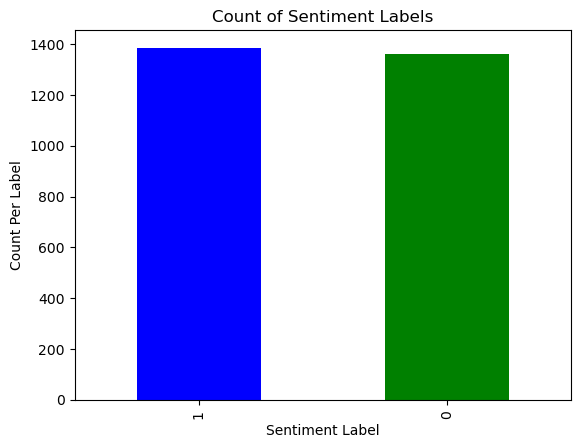

In [11]:
plt.title("Count of Sentiment Labels")
plt.xlabel("Sentiment Lable")
pd.value_counts(master_df['label']).plot.bar(color=['b', 'g']
                                             , xlabel='Sentiment Label'
                                             , ylabel='Count Per Label')

### For example: bizarre, good, bad, great, , cheap, smell, aroma. Look at some words that have bad anbd good connotation. This is not an exhausitve but it can be added to using the list that is included in the cell below.

In [12]:
word_list = ['bizarre','good','bad','great','firm','cheap','smell','aroma'
             ,'thrifty']

look_at_connotation(master_df, word_list)


Good Connotation:  bizarre
Empty DataFrame
Columns: [text, label]
Index: []

Bad Connotation:  bizarre
Empty DataFrame
Columns: [text, label]
Index: []

 ######################################

Good Connotation:  good
                                                 text  label
13                           Very good quality though      1
51  good protection and does not make phone too bu...      1

Bad Connotation:  good
                                                  text  label
81                                 Not a good bargain.      0
374  Not a good item.. It worked for a while then s...      0

 ######################################

Good Connotation:  bad
                                                   text  label
1135  You'll love it!  \t1\nThis movie is BAD.  \t0\...      1
1245  The last 15 minutes of movie are also not bad ...      1

Bad Connotation:  bad
                                    text  label
59   The buttons for on and off are bad.      0
126  Basically 

### Begin cleaning the data for further analysis. 

This is where the data will begin to be cleaned to be ready for use in the model.  This will accomplish removing punctuation, changing the text
to lowercase, tokenizing the data, and lemmatizing the data.  More information will be found in the Word document.

More information will be found in the Word document about cleaning the data (See section B).



### Remove punctuation from the the review text and repalce thecurrent string in the "text" column with it. 

Cleaning the data steps:

1. Remove punctuation.
2. Change the words to lowercase.
3. Create the first tokenization.


In [13]:
print("BEFORE Punctuation being removed: {}".format(master_df['text'].loc[247]))

# Apply the function across all rows of the 'text' column.
master_df['text'] = master_df['text'].apply(remove_punctuation)

print("AFTER Punctuation removed: {}".format(master_df['text'].loc[247]))

BEFORE Punctuation being removed: Nice headphones for the price and they work great!
AFTER Punctuation removed: Nice headphones for the price and they work great


### Change to lowercase.

In [14]:
print("\nBEFORE being changed to lowercase: {} \n".format(master_df['text'].loc[247]))

# Apply the lowercase function across all rows of the 'text' column.
master_df['text'] = master_df['text'].astype(str).str.lower() 

print("AFTER being changed to lowercase: {}\n".format(master_df['text'].loc[247]))


BEFORE being changed to lowercase: Nice headphones for the price and they work great 

AFTER being changed to lowercase: nice headphones for the price and they work great



## B2. Goals of Tokenization.

In this section there will be the code that was used to tokenize the data.  For more information please refer to Word document

### Begin to tokenize the words in the text column of the dataframe.

In [15]:
reg_exp = RegexpTokenizer('\w+')

print("BEFORE: {}".format(master_df['text'].loc[247]))

master_df['tokenized_text'] = master_df['text'].apply(reg_exp.tokenize)

print("AFTER : {}".format(master_df['tokenized_text'].loc[247]))

BEFORE: nice headphones for the price and they work great
AFTER : ['nice', 'headphones', 'for', 'the', 'price', 'and', 'they', 'work', 'great']


### Remove the common stopwords from the dataframe.  

Only the common words will be removed from the text reviews.  There will be no custom list added to this assessment. It is possbile, but it will not be pursued during this assessment.

In [16]:
# This will retrieve the common stopwords.
stop_words = nltk.corpus.stopwords.words("english")


print("BEFORE revoving the stopwords: {}".format(master_df['text'].loc[247]))

master_df['tokenized_text'] = master_df['tokenized_text'].apply(
    lambda sw : [word for word in sw if word not in stop_words])

print("AFTER removing the stopwords: {}".format(master_df['tokenized_text'].loc[247]))

BEFORE revoving the stopwords: nice headphones for the price and they work great
AFTER removing the stopwords: ['nice', 'headphones', 'price', 'work', 'great']


### Remove words that do not show up often.

In [17]:
print("REVIEW WORD STRING: {}".format(master_df['tokenized_text'].loc[247]))

master_df['review_word_str'] =master_df['tokenized_text'].apply(lambda rws : 
            ' '.join([wrd for wrd in rws if len(wrd) > 2]))

print("REVIEW WORD STRING: {}".format(master_df['review_word_str'].loc[247]))

REVIEW WORD STRING: ['nice', 'headphones', 'price', 'work', 'great']
REVIEW WORD STRING: nice headphones price work great


### Create a list with all the words.  This is to be used to show the frequency of the words that are in the data. 
**Note:** May need to run the commented command to download 'punkt'.

In [18]:
all_words_str = ' '. join([token for token in master_df['review_word_str']])

tokenized_words = nltk.tokenize.word_tokenize(all_words_str)

freq_dist = FreqDist(tokenized_words)

minimum = 2
master_df['freq_dist_str'] = master_df['tokenized_text'].apply(lambda fd: ' '.join([word for word in fd if freq_dist[word] >= minimum]))

### Lemmatize the words to get similar word roots.
Using the **WordNetLemmatizer** to get the "root" of the words that are in the review.w.

In [19]:
# Create a WordNetLemmitizer object.
wnl_lemmatizer = WordNetLemmatizer()

print("BEFORE being lemmatized: {}".format(master_df['text'].loc[247]))

master_df['lemmatized_text'] = master_df['freq_dist_str'].apply(wnl_lemmatizer.lemmatize)

print("AFTER being lemmatized : {}".format(master_df['lemmatized_text'].loc[247]))


# Call the find common words function.
freq_dist = find_common_words(10,'lemmatized_text')

print(freq_dist)

BEFORE being lemmatized: nice headphones for the price and they work great
AFTER being lemmatized : nice headphones price work great
good     229
great    208
movie    181
phone    165
film     163
one      145
like     125
food     125
place    114
time     112
dtype: int64


### Create a graph of the common words in the data. 

This is to show the distribution graphically and will later be represented in a visual device called a WordCloud.


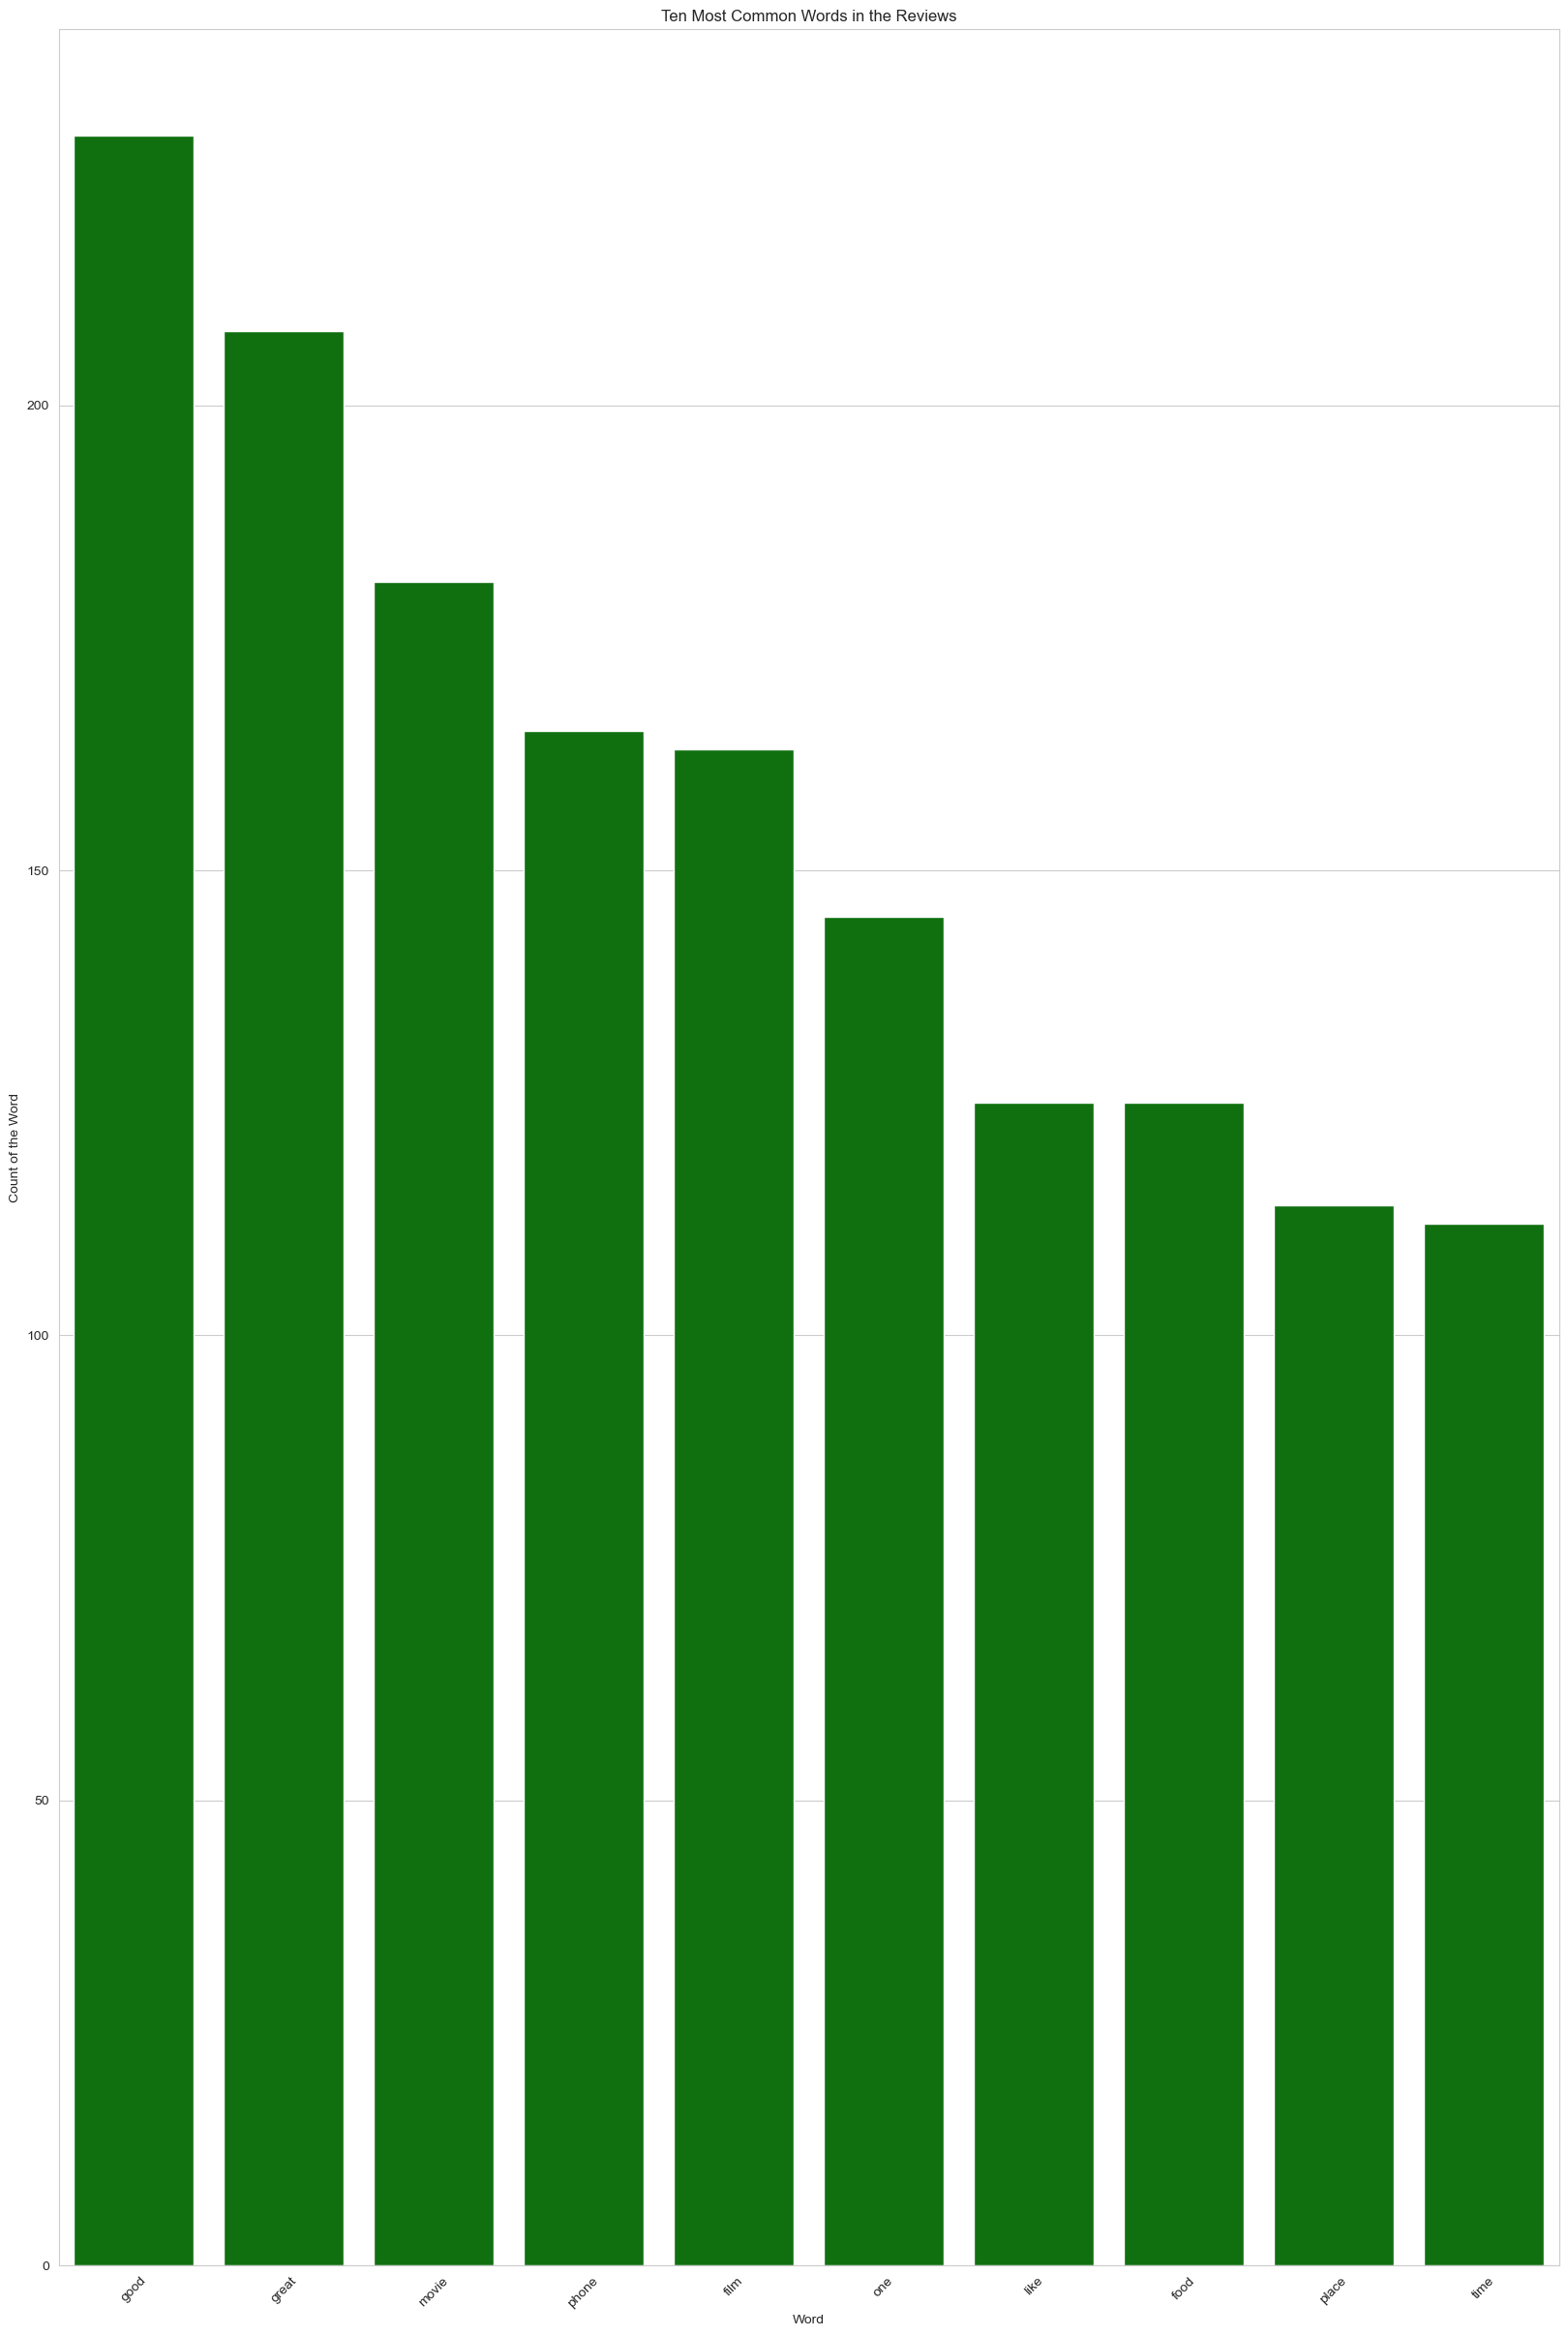

In [20]:

plt.figure(figsize=(20, 30))

sns.set_style("whitegrid")
ax = sns.barplot(x=freq_dist.index, y=freq_dist.values
            , color='green').set(title="Ten Most Common Words in the Reviews"
                                 , xlabel='Word', ylabel='Count of the Word')
sns.set(font_scale=5)
plt.xticks(rotation=45)                 
plt.show()



### Create a WordCloud of the words.

This is visualize the occurence of the words in a more visually pleasing manner.

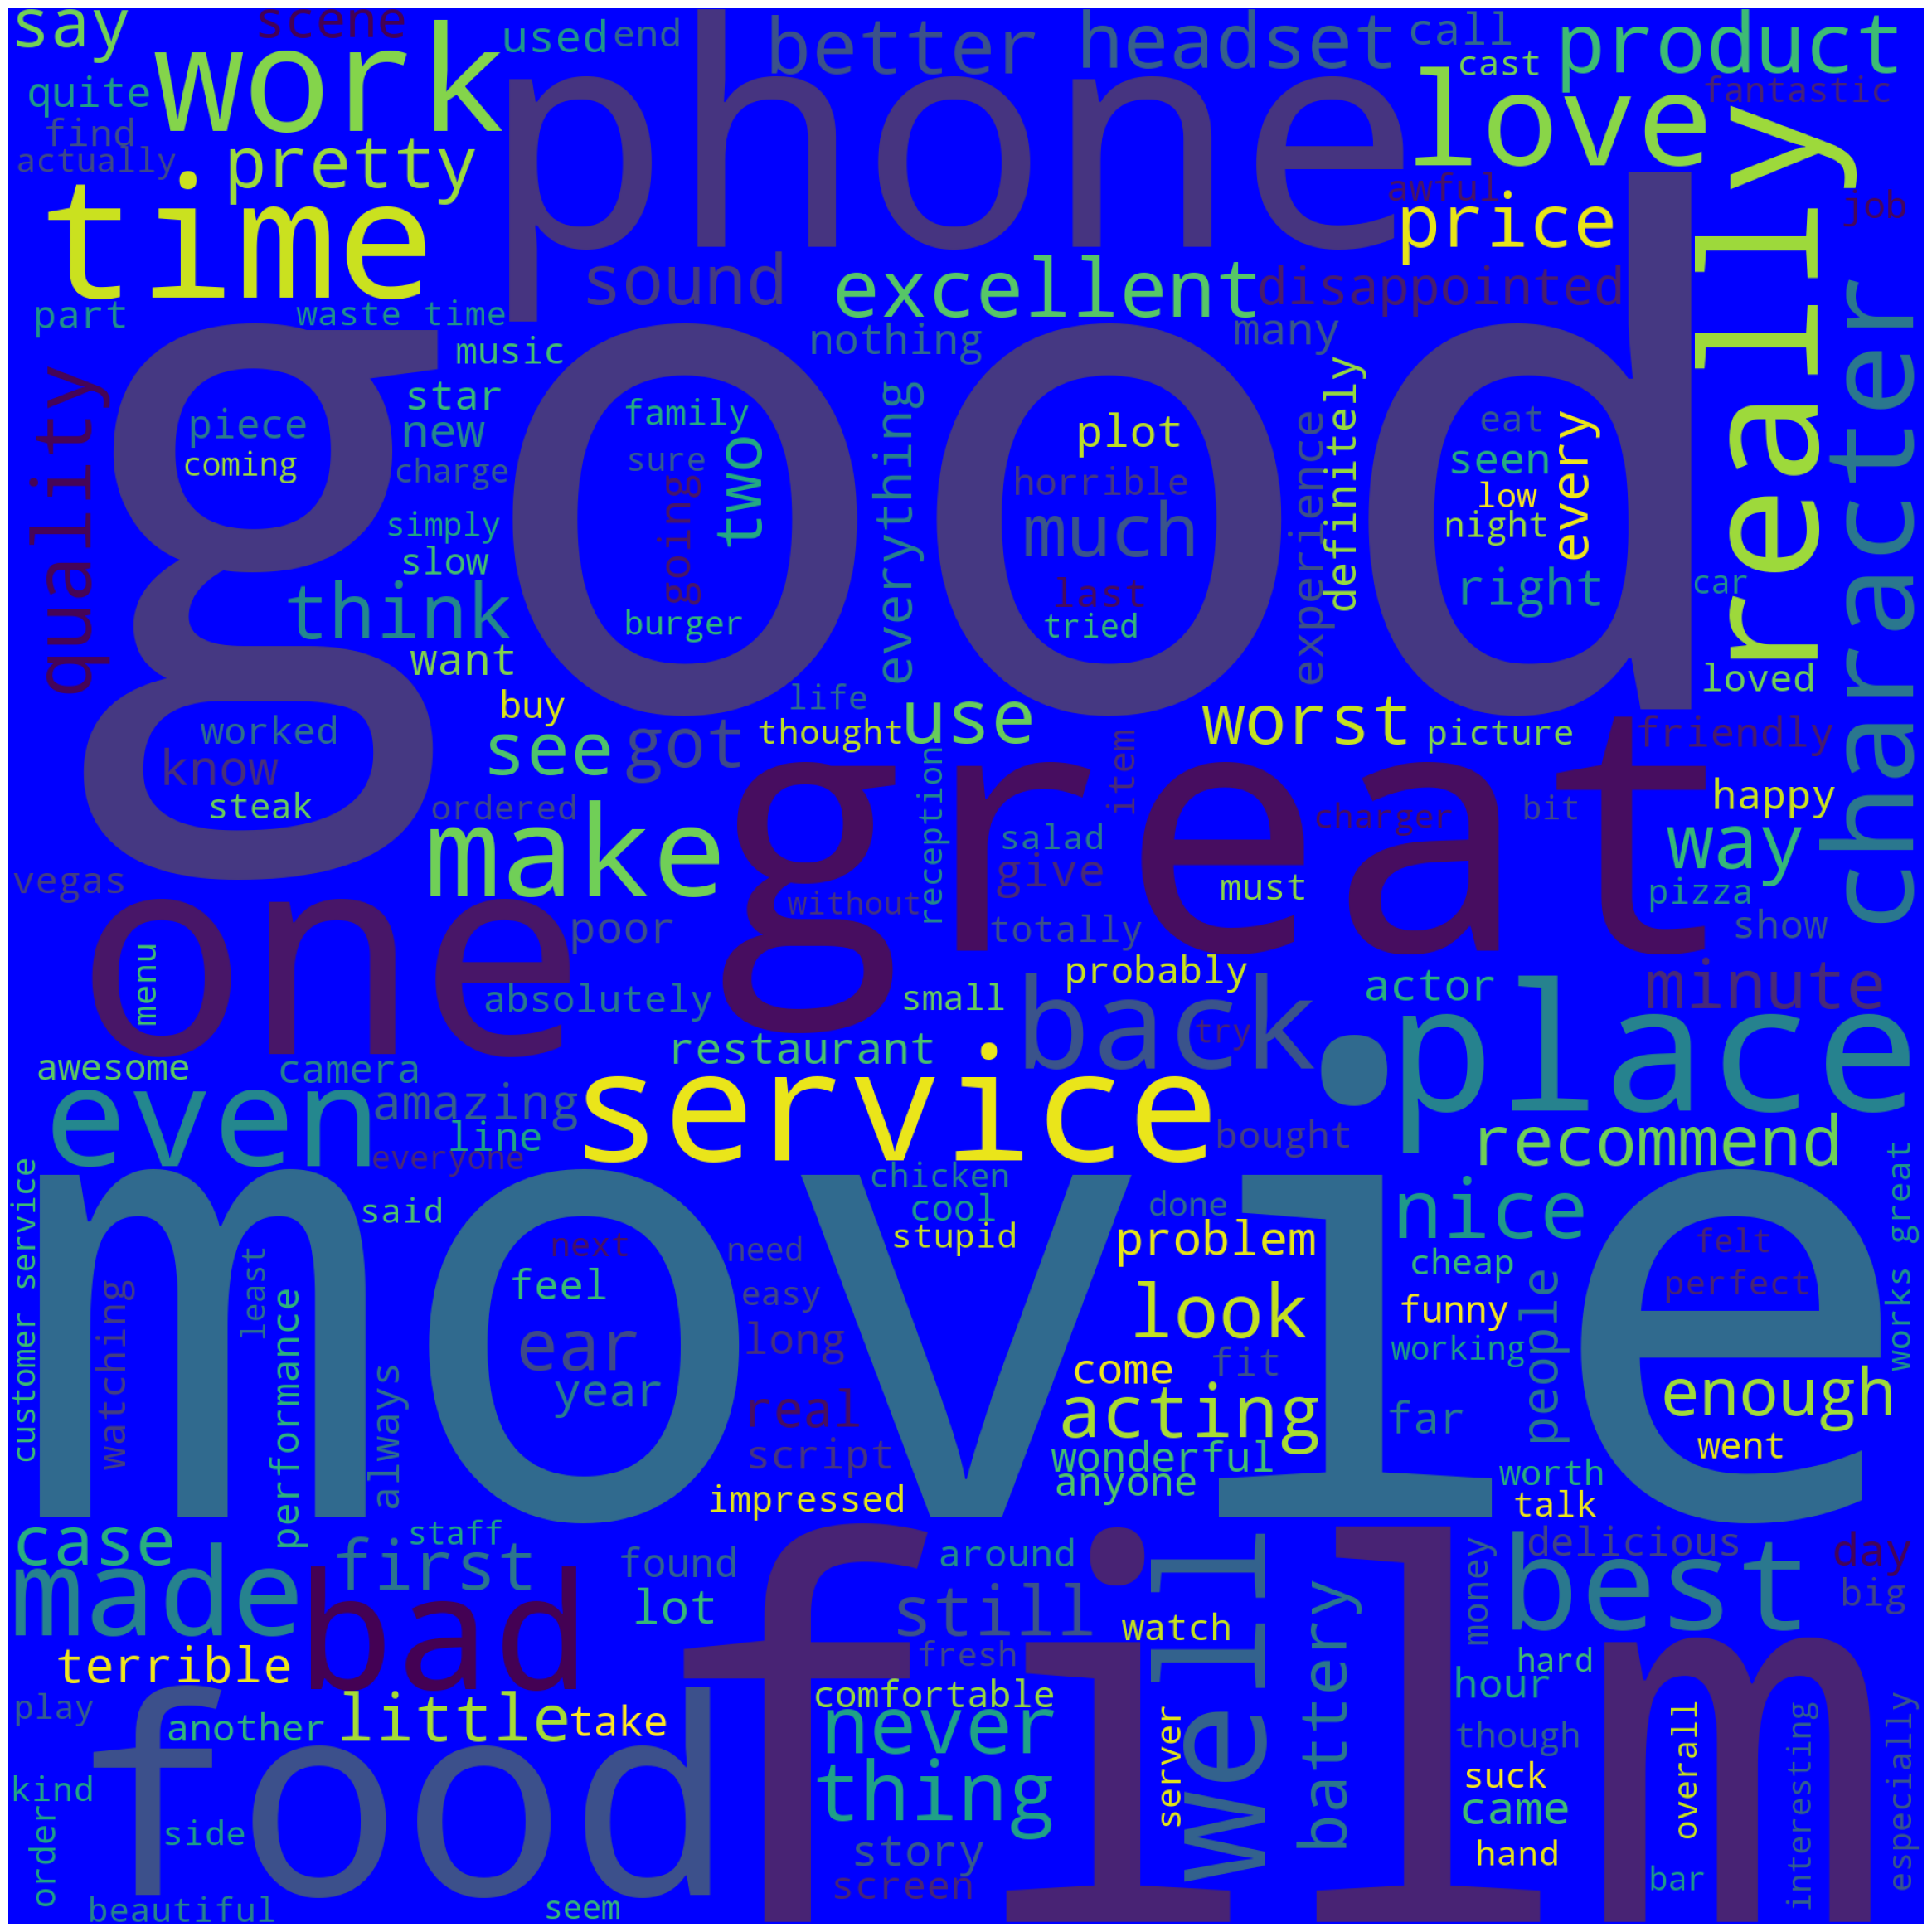

In [21]:
all_words = " ". join([word for word in master_df['lemmatized_text']])

create_wordcloud(plot_title="The Word Cloud", plot_data=all_words)

### Split the data into train and test sets. 

In [22]:
X = master_df['lemmatized_text']
y = master_df['label']

# Test split size.
test_split = 0.20         

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=247)


In [23]:
# Print a sample of the data from the test and training sets. 
print(X_train[0:3])

print('\nX_train shape-type: {}-{}'.format(X_train.shape, type(X_train)))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape-type: {} {}'.format(y_train.shape, type(y_train)))
print('y_test shape: {}'.format(y_test.shape))

1828    coming like underwhelming relationship wait pe...
1815                       back second time still amazing
670                 extremely slow takes forever anything
Name: lemmatized_text, dtype: object

X_train shape-type: (2198,)-<class 'pandas.core.series.Series'>
X_test shape: (550,)
y_train shape-type: (2198,) <class 'pandas.core.series.Series'>
y_test shape: (550,)


## Create the First Sequential Model.

This section will conatin the first attempt to create a sequential model.  The following citations wwere sued t ohelp create the code found in this section.

All the code below will make some sue of the citaions that are provided below.
- (tf.keras.preprocessing.text.Tokenizer, n.d.)
- (What Does Keras Tokenizer Method Exactly Do?, n.d.)

In [24]:
number_of_token_words = 2026

max_length = 64

keras_tokenizer = Tokenizer(num_words=number_of_token_words)

### Fit the data using the training dataset. Used to update to the internal vocabulary.  See citation given at the beginning of this section.

In [25]:
keras_tokenizer.fit_on_texts(X_train)

### Use **texts_to_sequences** to transform each sequence into a list of numerics. See citation above.

In [26]:
X_train = keras_tokenizer.texts_to_sequences(X_train)
X_test = keras_tokenizer.texts_to_sequences(X_test)

vocabulary_size = len(keras_tokenizer.word_index) +1

In [27]:
print(vocabulary_size)

2026


## B3. The Padding Process.

This section will handle the padding process and what it entails.  For in depth information please refer to the Word document.  Please refer to section in the Word document for this information. 

In [28]:
##############################################################################
# Add Padding to the numeric representations.
###############################################################################

X_train = ps(X_train, padding='post', maxlen=max_length)
X_test = ps(X_test, padding='post',maxlen=max_length)


In [29]:
# print and example of a padded sequence.
X_test[247]

array([ 94,   8,  44, 358, 193,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## B4. The Categories of Sentiment.

This section will handle the categories of sentiment and what it entails.  For in depth information please refer to the Word document.  Please refer to section in the Word document for this information.  There is no code for this section.

## B5. Data Preparation.

This section will handle data preparation and what it entails.  For in depth information please refer to the Word document.  Please refer to section in the Word document for this information.  There is no code for this section.

## B6. Copy of the Cleaned Data.

This section has the code to create a copy of the cleaned data. For in depth information please refer to the Word document.  Please refer to section in the Word document for this information.  There is no code for this section.

In [30]:
# Export the data to the CSV file. 
#master_df.to_csv("Heino D213 Task 2 Cleaned.csv", index=True, header=True)

## Define the model and its parameters.


In [31]:
# Create the compiled model.**************************************************

output_dimension = 1 #1
seq_model = get_sequential_model(vocabulary_size, output_dimension
                                 , max_length, drop=0.05) # 0.28, 0.05


### Compile the model. 

In [32]:
seq_model.compile(optimizer='adam', loss='binary_crossentropy'
                  , metrics=['accuracy'])

### Fit the model.
This section uses the concept ofeEarly stopping to make usre the model does not overfit the data.The code from this section uses the following citation. (Brownlee, 2020)

In [33]:
batch_sze = 32
number_of_epochs = 300

# Create a callback for stopping the model when training is no longer producing satisfactory results.

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=12, verbose=1) #3 10
#early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=30, verbose=1)

model_history = seq_model.fit( X_train, y_train, batch_size=batch_sze, epochs=number_of_epochs
                             , verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/300
69/69 [==============================] - 1s 6ms/step - loss: 0.6938 - accuracy: 0.4982 - val_loss: 0.6922 - val_accuracy: 0.5582
Epoch 2/300
69/69 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.6010 - val_loss: 0.6908 - val_accuracy: 0.5527
Epoch 3/300
69/69 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.6297 - val_loss: 0.6872 - val_accuracy: 0.6164
Epoch 4/300
69/69 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.7002 - val_loss: 0.6813 - val_accuracy: 0.6636
Epoch 5/300
69/69 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.7652 - val_loss: 0.6722 - val_accuracy: 0.6909
Epoch 6/300
69/69 [==============================] - 0s 3ms/step - loss: 0.6534 - accuracy: 0.8107 - val_loss: 0.6601 - val_accuracy: 0.7145
Epoch 7/300
69/69 [==============================] - 0s 2ms/step - loss: 0.6357 - accuracy: 0.8267 - val_loss: 0.6468 - val_accuracy: 0.7273
Epoch 8/300
6

# Part III: Network Architecture.
Most of the sections that fall under this header can be found in the Word documnet. This section will only contian the summary of the out for the model Sections C2 and C3 will be adiscussed in the written document. Please refer to this document for these sections. 


## C1. Model Summary. 

This section provides the model summary for the model. Code to create this summary can be found below.

In [34]:
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 64, 1)             2026      
                                                                 
 dropout (Dropout)           (None, 64, 1)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,091
Trainable params: 2,091
Non-trainable params: 0
_________________________________________________________________


# Part IV: Model Evaluation.
The following sections will be discussed in the Word document in more detail:
- D1. Stopping criteria, epochs
- D2. Assessment fitness of the model.
- D3. Visualizations of the traning process. (partial)
- D4. Discussion of predictive accruace

Please refer to this document for these sections.

### Plotting the summary of the training history.

This section shows the plot of the training history.  It will show a plot showing the accuracy of the model over the executed epochs.  Since an early stopping callback was used. There will be only a few epochs entered into.  This is to avoid problmes like overfitting. Please refer to previous sections for the early stopping code and citations.

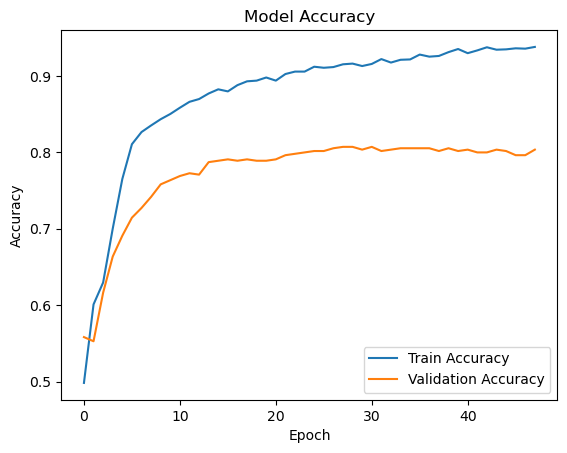

In [35]:
# Accuracy. *******************************************

plt.rcdefaults()
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])

plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy','Validation Accuracy'])
plt.show()

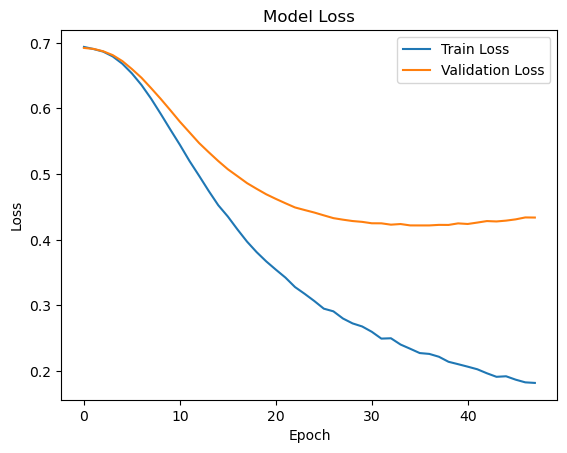

In [36]:
# Plot the loss for the model. ***********************************************
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])

plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss','Validation Loss'])
plt.show()

### Look at the final score for the model.

In [37]:
score= seq_model.evaluate(X_test, y_test, verbose=1)

print("\n\nTest loss: ", score[0])
print("Test accuracy: ", score[1])

18/18 [==============================] - 0s 2ms/step - loss: 0.4339 - accuracy: 0.8036


Test loss:  0.4339071810245514
Test accuracy:  0.803636372089386


# Part V: Summary and Recommendations.

This section will have code that will be used to 
## E1. Save Model Code.



In [38]:
# Add save model code using SaveModel. 

# Retrieve the current time.
#current_time = datetime.now()

#date_time = current_time.strftime("_%y%m%d_%H%M")

# save the model with the time and date.
#seq_model.save('Models/' + date_time)



## F1. Functionality of the Neural Network.

This discussion will be found in the Word document that accompanies this Jupyter Notebook.  Please refer to this document for this information.

## G1. Course of Action.

The course of action based on the findings of this model ccan be found in the Word document that accompanies this Jupyter Notebook. Please refer to  this document for this section of the assessment.


# Part VI: Reporting.

## H.  IDE Environment

This Jupyter Notebook will be submitted as proof of industry relevant IDE.  This will be submitted as a PDF along with other required documents.

## I. Web Resources.

All web resources that required a citation will be found in the Word document that accompanies this Jupyter Notebook.


## J. In-text Citations.

All in-text citations will be in the Word document.  Please refer to this document for this information.
